In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc as pm
import arviz as az
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
sns.set_style("whitegrid")

In [2]:
df_tr = pd.read_csv('train_clf.csv')
df_tes = pd.read_csv('test_clf.csv')

In [3]:
df_tr

,a,b,c,y
0,6.061051,8.085120,-0.901515,0.0
1,8.625052,9.712480,0.410613,0.0
2,1.705775,0.676360,1.823731,1.0
3,2.170837,1.363792,1.311898,1.0
4,0.467688,1.271315,0.085517,1.0
...,...,...,...,...
95,2.491194,0.685869,3.200508,1.0
96,5.798723,6.416613,0.224369,0.0
97,6.553074,8.428001,-0.687934,0.0
98,1.441131,4.369016,-1.913370,1.0


In [4]:
x = np.array(df_tr[['a', 'b', 'c']])
y = np.array(df_tr['y'])
x_1 = (x - x.mean())/x.std()
N = 3

## Задание 1. Построить модель Pymc с множественной логистической регрессией для решения задачи. Предсказать класс на test_clf.

In [5]:
x_means = x.mean(axis=0)
# x_1 = (x - x_means)

In [6]:
with pm.Model() as model_1:
    α_tmp = pm.Normal('α_tmp', mu=0, sigma=10)
    β = pm.Normal('β', mu=0, sigma=1, shape=N)

    μ = α_tmp + pm.math.dot(x_1, β)
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    α = pm.Deterministic('α', α_tmp - pm.math.dot(β,x_means))
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * (x_1[:,0]+x_means[0]))

    yl = pm.Bernoulli('yl', p=θ, observed=y)

    trace_1 = pm.sample(2000, chains = 4, cores = 4)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_tmp, β]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 17 seconds.


In [7]:
az.summary(trace_1, var_names=['α','β'] )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,27.269,4.228,19.154,34.873,0.055,0.040,5868.0,4995.0,1.0
β[0],-2.617,0.722,-4.068,-1.348,0.013,0.009,3199.0,4372.0,1.0
β[1],-2.471,0.693,-3.720,-1.110,0.012,0.008,3597.0,4581.0,1.0
β[2],-0.172,0.647,-1.452,0.983,0.012,0.009,2750.0,3916.0,1.0


NameError: name 'trace_2' is not defined

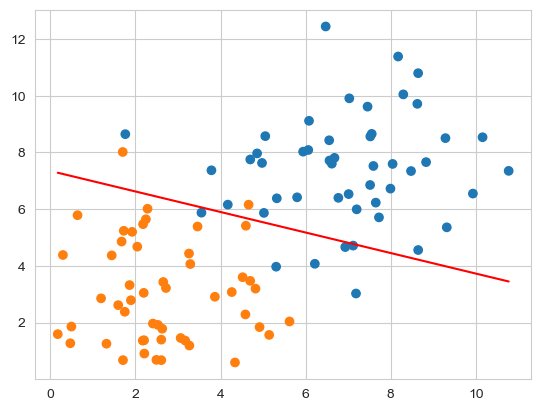

In [8]:
idx = np.argsort(x_1[:,0])
bd = trace_1.posterior['bd'].mean(("chain", "draw"))[idx]

plt.scatter(x[:,0], x[:,1], c=[f'C{i}' for i in pd.Categorical(y).codes])

plt.plot(x[:,0][idx], bd, color='r');
az.plot_hdi(x[:,0], trace_2.posterior['bd'], color='r')

In [10]:
az.summary(trace_1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α_tmp,1.943,0.713,0.526,3.226,0.013,0.009,3193.0,4085.0,1.0
β[0],-2.617,0.722,-4.068,-1.348,0.013,0.009,3199.0,4372.0,1.0
β[1],-2.471,0.693,-3.720,-1.110,0.012,0.008,3597.0,4581.0,1.0
β[2],-0.172,0.647,-1.452,0.983,0.012,0.009,2750.0,3916.0,1.0
θ[0],0.046,0.028,0.006,0.099,0.000,0.000,7507.0,6495.0,1.0
...,...,...,...,...,...,...,...,...,...
bd[95],6.445,0.576,5.656,7.416,0.010,0.007,2681.0,3873.0,1.0
bd[96],5.248,0.258,4.803,5.651,0.003,0.002,7014.0,5664.0,1.0
bd[97],4.975,0.389,4.346,5.534,0.006,0.004,4647.0,5048.0,1.0
bd[98],6.825,0.795,5.736,8.132,0.014,0.010,2650.0,3731.0,1.0


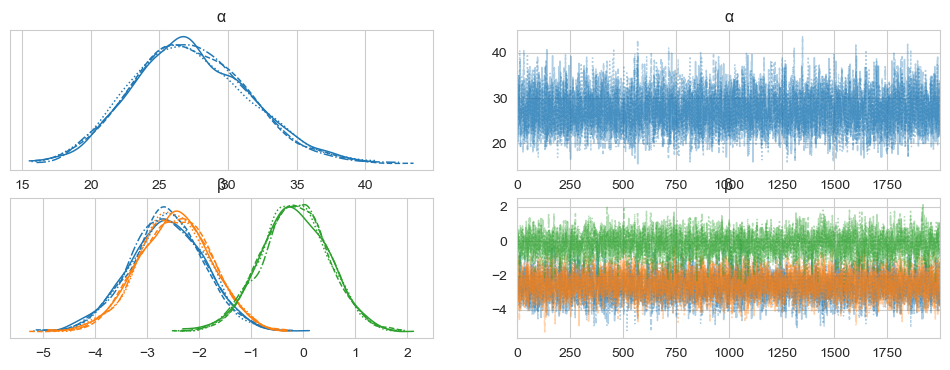

In [11]:
az.plot_trace(trace_1, var_names = ['α','β'],compact=True);

In [12]:
α_tmp = trace_1.posterior['α_tmp'].mean(("chain", "draw")).values
β = trace_1.posterior['β'].mean(("chain", "draw")).values


In [13]:
z = α_tmp + np.dot(df_tes, β)


predicted_probabilities = 1 / (1 + np.exp(-z))

threshold = 0.5
y_pred = (predicted_probabilities > threshold).astype(int)

In [14]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [15]:
from sklearn.metrics import accuracy_score
y_true = pd.read_csv('test_Y_true_clf.csv')
accuracy_score(y_true, y_pred)

0.51

## Задание 2. Построить модель Pymc с порождающим множественным логистическим классификатором для решения задачи. Предсказать класс на test_clf.

In [23]:
# Для каждого класса своя модель
with pm.Model() as lda:
    m1 = pm.Normal('m1', mu=0, sigma=10, shape=3)
    m2 = pm.Normal('m2', mu=0, sigma=10, shape=3)

    f1 = pm.Normal('f1', mu=m1, sigma=1, observed=x[y == 0])
    f2 = pm.Normal('f2', mu=m2, sigma=1, observed=x[y == 1])

    lda_1, lda_2 = [pm.sample(3000, chains=4, cores=4) for _ in range(2)]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m1, m2]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 15 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m1, m2]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 14 seconds.


In [24]:
az.summary(lda_1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m1[0],6.915,0.145,6.640,7.188,0.001,0.001,18319.0,9319.0,1.0
m1[1],7.394,0.143,7.111,7.650,0.001,0.001,21365.0,9714.0,1.0
m1[2],0.551,0.143,0.273,0.806,0.001,0.001,18157.0,9772.0,1.0
m2[0],2.656,0.141,2.398,2.923,0.001,0.001,20780.0,9969.0,1.0
m2[1],3.061,0.140,2.803,3.330,0.001,0.001,22168.0,10076.0,1.0
m2[2],0.580,0.141,0.320,0.848,0.001,0.001,16845.0,10414.0,1.0


In [25]:
az.summary(lda_2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m1[0],6.915,0.143,6.650,7.194,0.001,0.001,18461.0,9822.0,1.0
m1[1],7.395,0.142,7.125,7.660,0.001,0.001,18484.0,9141.0,1.0
m1[2],0.548,0.144,0.288,0.829,0.001,0.001,18404.0,10069.0,1.0
m2[0],2.658,0.142,2.392,2.925,0.001,0.001,20870.0,9828.0,1.0
m2[1],3.060,0.141,2.800,3.323,0.001,0.001,16458.0,10235.0,1.0
m2[2],0.581,0.141,0.324,0.853,0.001,0.001,18184.0,10258.0,1.0


In [26]:
posterior_m1 = lda_1.posterior['m1'].mean(axis=(0, 1))
posterior_m2 = lda_2.posterior['m2'].mean(axis=(0, 1))

m10, m11, m12 = posterior_m1[:3]
m20, m21, m22 = posterior_m2[:3]

In [27]:
dist1 = np.sqrt(np.sum((df_tes - [m10, m11, m12])**2, axis=1))
dist2 = np.sqrt(np.sum((df_tes - [m20, m21, m22])**2, axis=1))

y_pred = np.where(dist1 < dist2, 0, 1)


TypeError: loop of ufunc does not support argument 0 of type DataArray which has no callable sqrt method

In [ ]:
y_pred

In [22]:
from sklearn.metrics import accuracy_score
y_true = pd.read_csv('test_Y_true_clf.csv')
accuracy_score(y_true, y_pred)

0.51